In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import neptune.new as neptune

In [2]:
def show_image(data_dir='/Users/nielspace/Documents/data/birds/train/'):
    list_dir = os.listdir(data_dir)
    rand_d = np.random.randint(0, len(list_dir))
    rand_d = list_dir[rand_d]
    img_dir = data_dir+rand_d
    image = os.listdir(img_dir)
    rand_i = np.random.randint(len(image))
    img_src = img_dir+'/'+image[rand_i]
    img = cv2.imread(img_src)
    resize = cv2.resize(img, (100,100))
    plt.figure(figsize=(10,8))
    plt.imshow(resize)
    plt.title(rand_d)
    
    
#     plt.axis('off')
    plt.show()

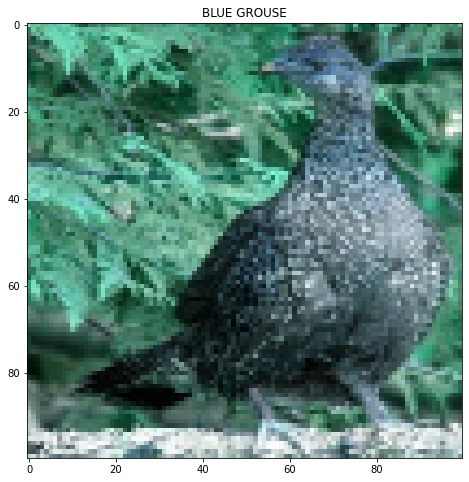

In [3]:
show_image()

# Create Dataset

In [4]:
train_dir = '/Users/nielspace/Documents/data/birds/train/'
val_dir = '/Users/nielspace/Documents/data/birds/valid/'
test_dir = '/Users/nielspace/Documents/data/birds/test/'

bs = 1
crop_size = 100

def dataset(bs, crop_size):
    transformations = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(100),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
    test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
    valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs, )
    val_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)

    
    return train_loader, val_loader, test_loader

In [26]:
train_data, valid_data, test_data = dataset(bs, crop_size)
len(train_data), len(valid_data), len(test_data)

(58388, 2000, 2000)

# Data Modeling

In [6]:
from attention import Attention
from transformer import Transformer, ViT

import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

In [7]:
model = ViT(
    
    image_size=100, 
    patch_size=10, 
    num_classes=400, 
    channels=3, 
    dim=64, 
    depth=6, 
    heads=8, 
    mlp_dim=128,

)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
run = neptune.init(
    project="nielspace/ViT-bird-classification",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjRhYzI0Ny0zZjBmLTQ3YjYtOTY0Yi05ZTQ4ODM3YzE0YWEifQ==",
)

In [25]:
len(valid_data.dataset)

2000

In [23]:
train_loss_history, test_loss_history = [], []
N_EPOCHS = 2
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    for i, (data, target) in tqdm(enumerate(train_data), total=len(train_data), desc="Training"):
        total_samples = len(train_data.dataset)
        model = model.to('mps')
        x = data.to('mps')
        target = target.to('mps')
        optimizer.zero_grad()
        output = F.log_softmax(model.forward(x), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(train_data)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            train_loss_history.append(loss.item())
            
    model.eval()
    total_samples = len(valid_data.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for i, (data, target) in tqdm(enumerate(valid_data), total=len(train_data), desc="Valuation"):
            model = model.to('mps')
            x = data.to('mps')
            target = target.to('mps')
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
            
            avg_loss = total_loss / total_samples
            test_loss_history.append(avg_loss)
            print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
                  '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
                  '{:5}'.format(total_samples) + ' (' +
                  '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

Epoch: 1


Training:   0%|                                                                               | 0/58388 [00:00<?, ?it/s]


NameError: name 'optimizer' is not defined

In [32]:
params = {"learning_rate": 0.001, "optimizer": "Adam"}
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()

https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.
All 22 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


In [10]:
from config import Config

In [19]:
PARAMS = {}
for key, val in Config.__dict__.items():
    if key not in ['__module__', '__dict__', '__weakref__', '__doc__']:
        PARAMS[key] = val
        
PARAMS

{'IMG_SIZE': 224,
 'CROP_SIZE': 224,
 'BATCH_SIZE': 128,
 'N_SAMPLES': 400,
 'N_TRAIN': 400,
 'N_VAL': 400,
 'N_TEST': 400,
 'LR': 0.003,
 'OPIMIZER': 'Adam',
 'N_CLASSES': 400,
 'N_CHANNELS': 3,
 'LATENT_DIM': 100,
 'N_ITER': 400,
 'OUTPUT': 'softmax',
 'LOSS_FN': 'nll_loss',
 'DEVICE': ['cpu', 'mps', 'cuda'],
 'N_EPOCHS': 100,
 'TRAIN_LOSS_HISTORY': [],
 'VAL_LOSS_HISTORY': []}